In [33]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain
from tf_pose.tensblur.smoother import Smoother

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# params 432, 368
w, h = 432, 368
image_path_source = './data/images/lea_source.jpg'
image_path_target = './data/images/lea_target_near.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)

In [3]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

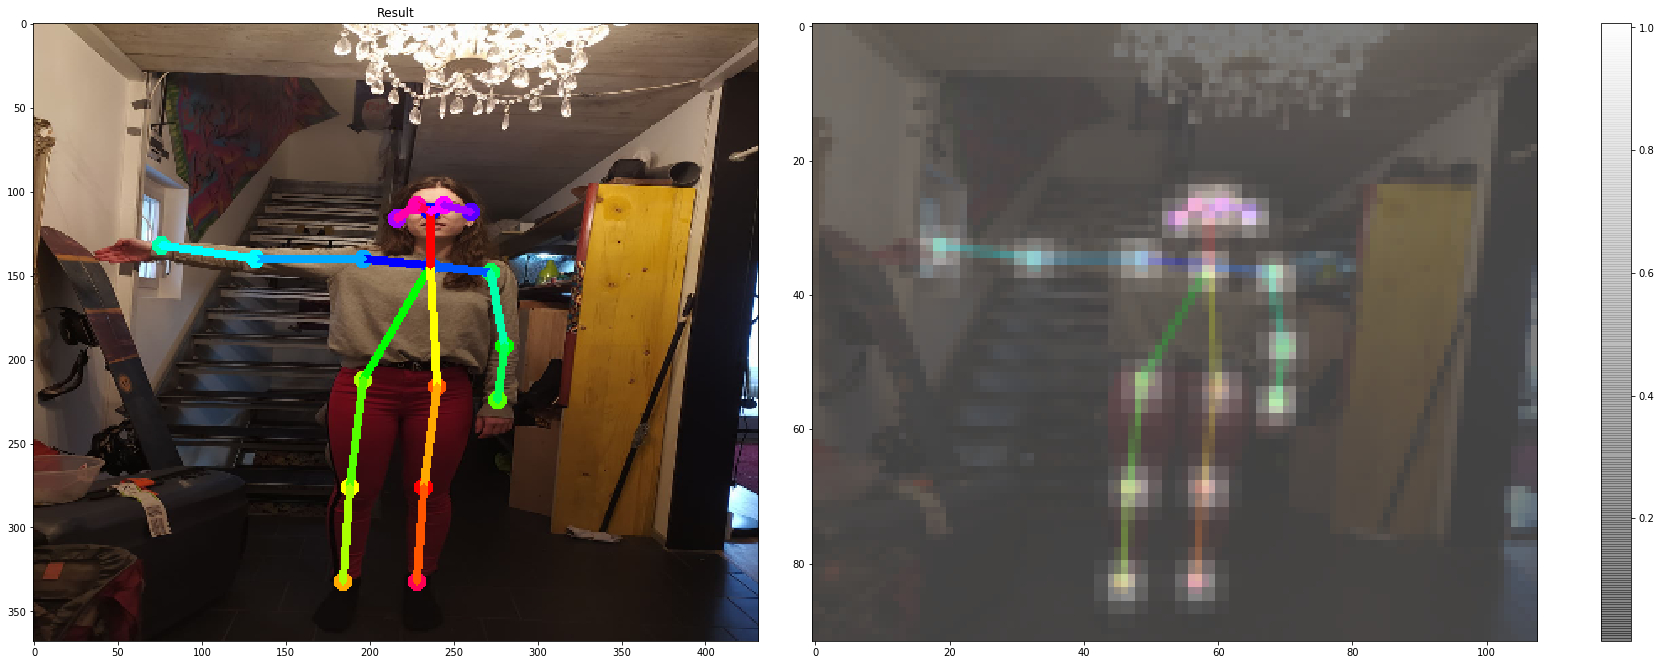

In [4]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

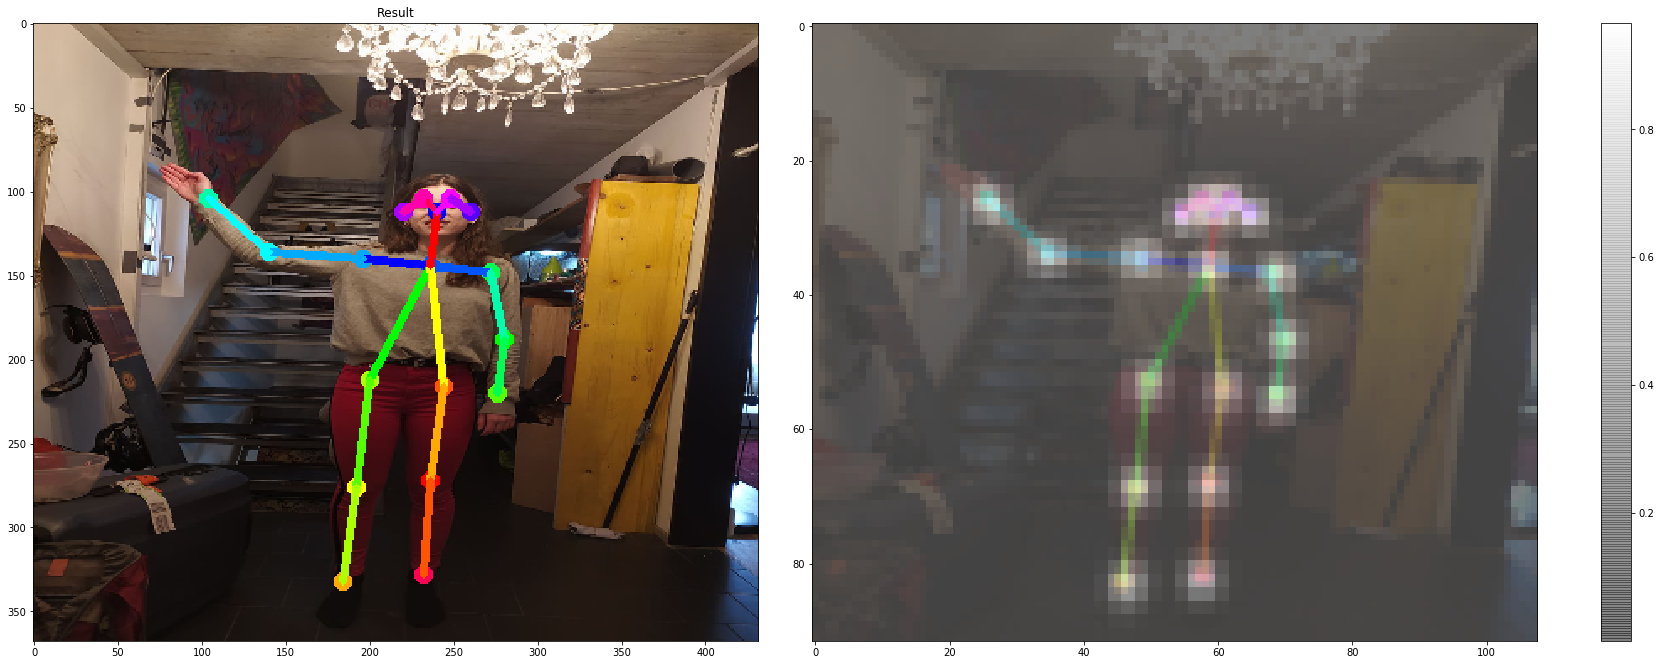

In [7]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

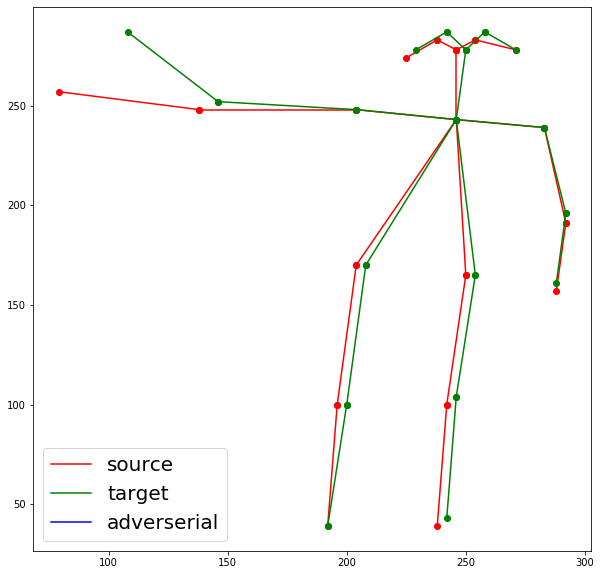

In [9]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [10]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


In [11]:
# change only the heatmap for the wrist and the required limb vector field
# wrist
temp_target = copy.deepcopy(source_np_heat)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]
target_np_heat = temp_target
ONLY_HEAT = True

# lower arm 
temp_target = copy.deepcopy(source_np_paf)
if ONLY_HEAT:
    LOWER_ARM_RIGTH = 3
    id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]
    temp_target[:, :, :, id] = target_np_paf[:, :, :, id]
    temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]

target_np_paf = temp_target

# set the correct peaks
temp_target = copy.deepcopy(source_np_peaks)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]
target_np_peaks = temp_target

# change the output as well
temp_target = copy.deepcopy(source_np)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np[:, :, :, CocoPart.RWrist.value]
if ONLY_HEAT:
    temp_target[:, :, :, id + 19] = target_np[:, :, :, id + 19]
    temp_target[:, :, :, id + 19 + 1] = target_np[:, :, :, id + 19 + 1]
target_np = temp_target

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


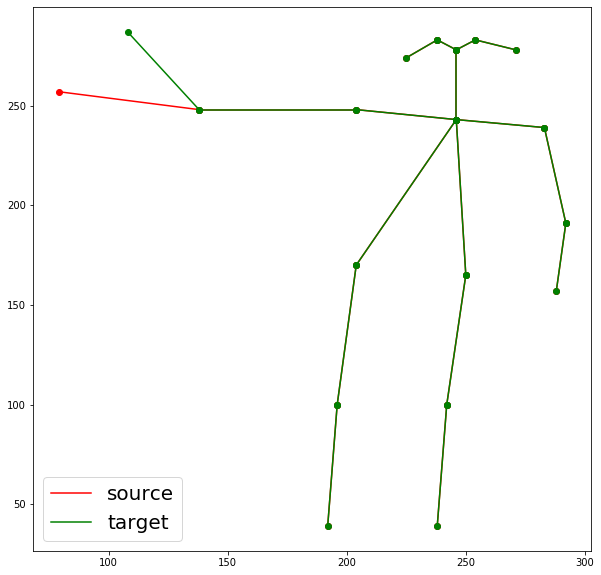

In [12]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [73]:
# the target state
def multi_stage_loss():
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))

    eps = tf.constant(0.05, name='Epsilon')


    losses_per_stage = []
    # compute loss per stage
    for stage in range(2, 7): 
        paf_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
        heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

        # check if concat works 
        # compute the loss for every channel
        loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
        loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))
        losses_per_stage.append(tf.reduce_sum([loss_paf, loss_heat]))

    # combined loss form every stage
    total_loss = tf.reduce_sum(losses_per_stage)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, total_loss

def final_stage_heat_loss(target_heat):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, total_loss

def final_stage_single_heat_loss(target_heat, index):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0][:, :, :, index]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, total_loss
# x_adv = e_source.tensor_image - eps * tf.sign(grad)
# x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
# x_adv = tf.stop_gradient(x_adv)
def final_stage_single_heat_upsampled_loss(target_heat, index):
    # No gradient defined for operation 'upsample_heatmat' (op type: ResizeArea)
    heat_op = e_source.graph.get_operation_by_name(f'upsample_heatmat').outputs[0][:, :, :, index]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_upsample_heatmat')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, total_loss

In [75]:
EPS = 0.1
STEPS = 1

adv_image = copy.deepcopy(image_source)
#target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
#grad_func, loss_func = final_stage_heat_loss(target_heat)

target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None))
grad_func, loss_func = final_stage_single_heat_loss(target_heat, CocoPart.RWrist.value)



for i in range(STEPS):    
    # compute gradient
    gradient = e_source.persistent_sess.run(
                grad_func,
                feed_dict={
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value],
                    #target_heat: target_np[:, :, :, :19],
                    # target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )

    # compute loss before applying the gradient
    loss_before = e_source.persistent_sess.run(
                loss_func,
                feed_dict={
                    #target_heat: target_np_heat[:, :, :, CocoPart.RWrist.value],
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value],
                    #target_heat: target_np[:, :, :, :19],
                    # target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )

    print(f'{i}: Loss: {loss_before}')

    adv_image = image_source - EPS * np.sign(gradient[0])




human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])

human_adv = e_source.inference(np.clip(adv_image, 0, 255), resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)


def print_image_Stats(img):
    print(f'Min: {np.min(img)}')
    print(f'Max: {np.max(img)}')
    print(f'Avg: {np.average(img)}')
    
def compare_poses(pose1, pose2):
    total_diff = 0
    cur_max = 0
    most_moved_part = ''
    if(len(pose1.body_parts) != len(pose2.body_parts)):
        print('Poses have different length of body parts')
        return 0, 'NONE'
    for i in pose1.body_parts.keys():
        part1 = pose1.body_parts[i]
        part2 = pose2.body_parts[i]
        part1_pos =  np.array([part1.x, part1.y])
        part2_pos =  np.array([part2.x, part2.y])
        cur_diff = np.linalg.norm(part1_pos - part2_pos)
        if cur_diff > cur_max:
            most_moved_part = part1.get_part_name()
            cur_max = cur_diff
        total_diff += cur_diff
    return total_diff, most_moved_part

    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

0: Loss: 1.8779425621032715
Min: 0
Max: 255
Avg: 64.82726323470209
Min: -0.10000000149011612
Max: 255.10000610351562
Avg: 64.82776641845703
The total diff is 0.030998389694041895 and the part moved the most is the CocoPart.LAnkle


2020-01-22 11:01:08,880 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)


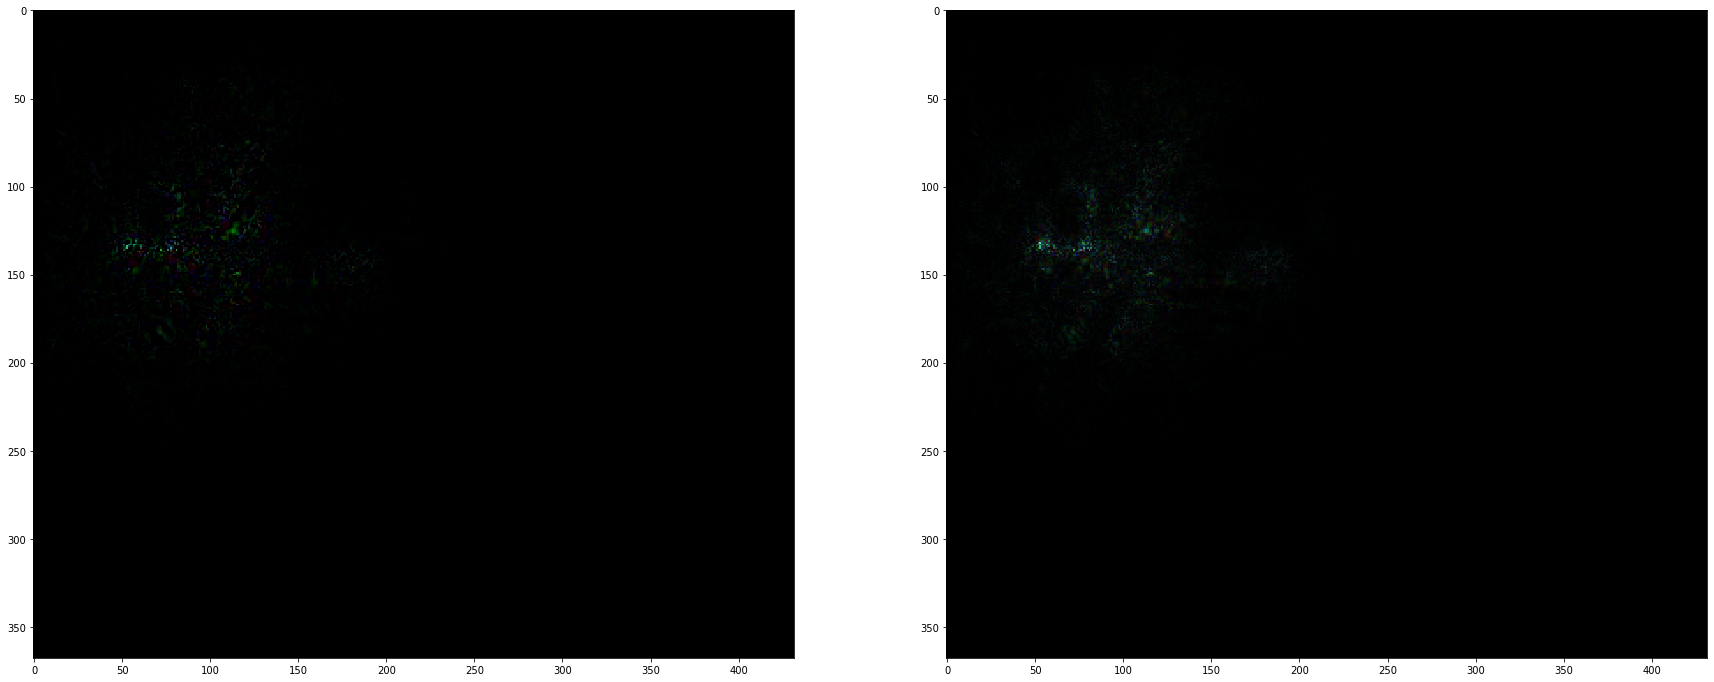

In [76]:
SCALE = 1000
print(gradient.shape)
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.abs(gradient[0] * SCALE), cmap='hot')

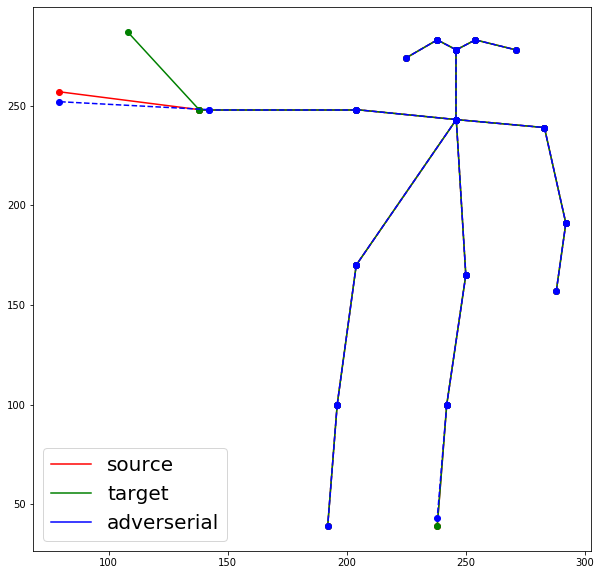

In [78]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

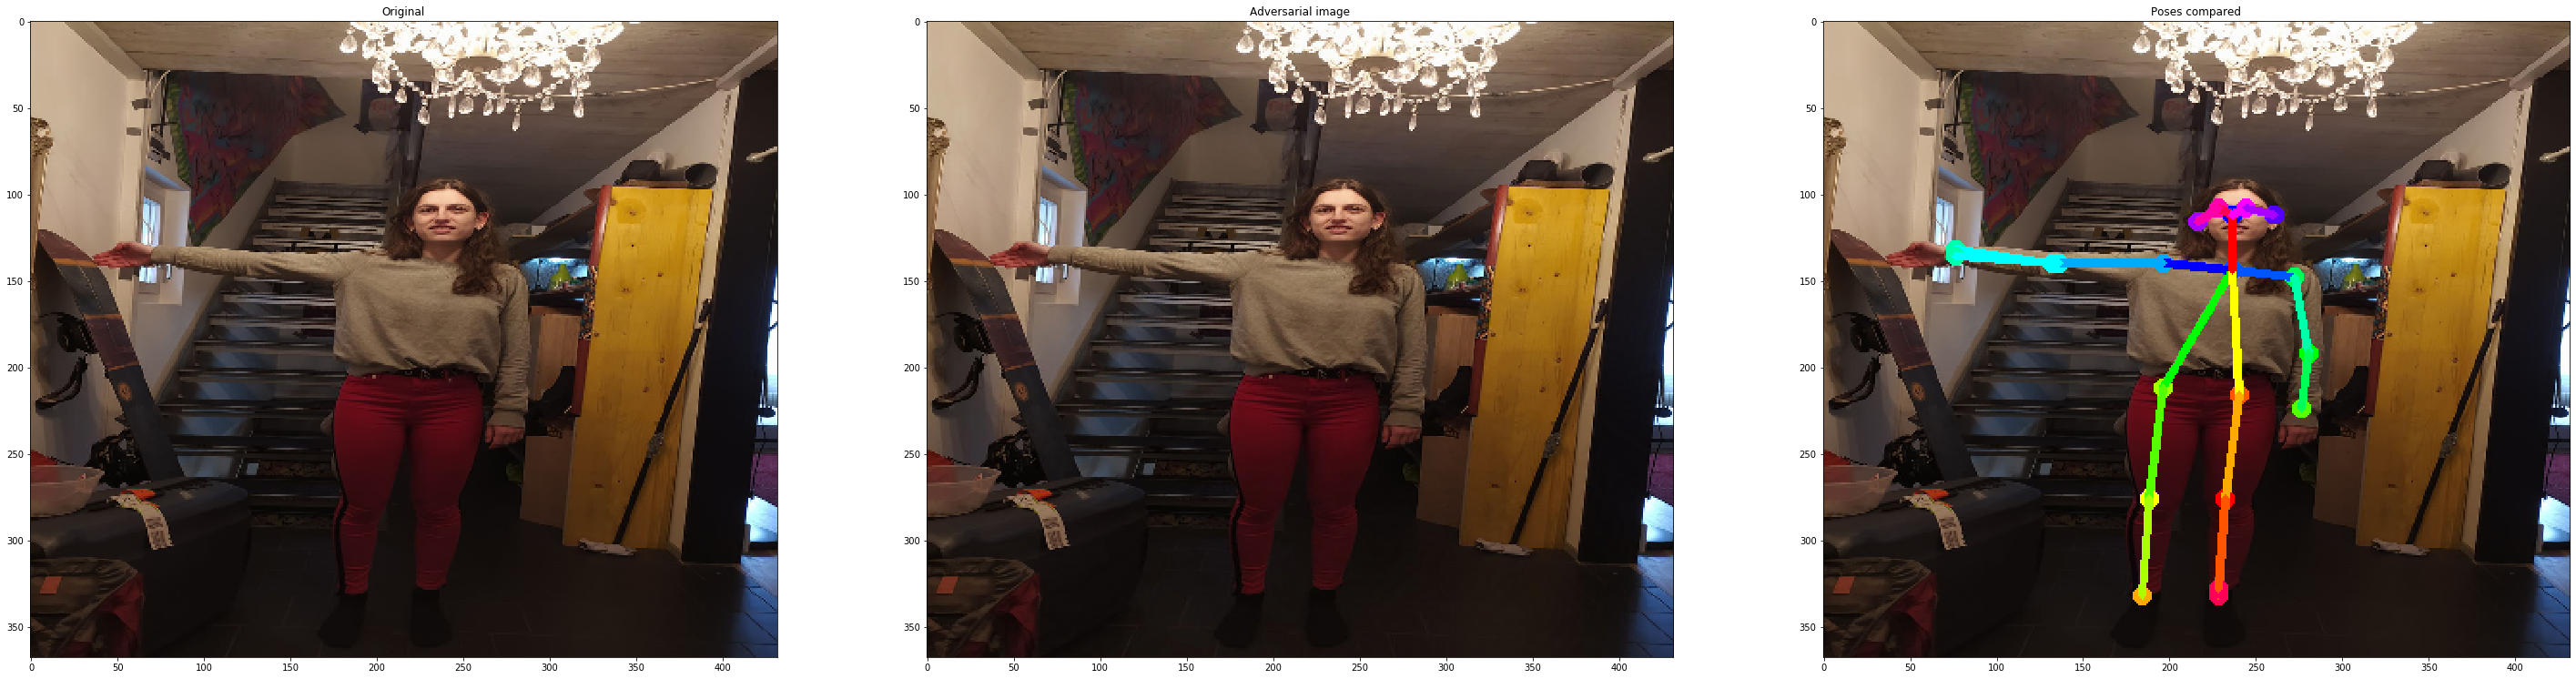

In [79]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 3, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

3.913613


Text(0.5, 1.0, 'Difference')

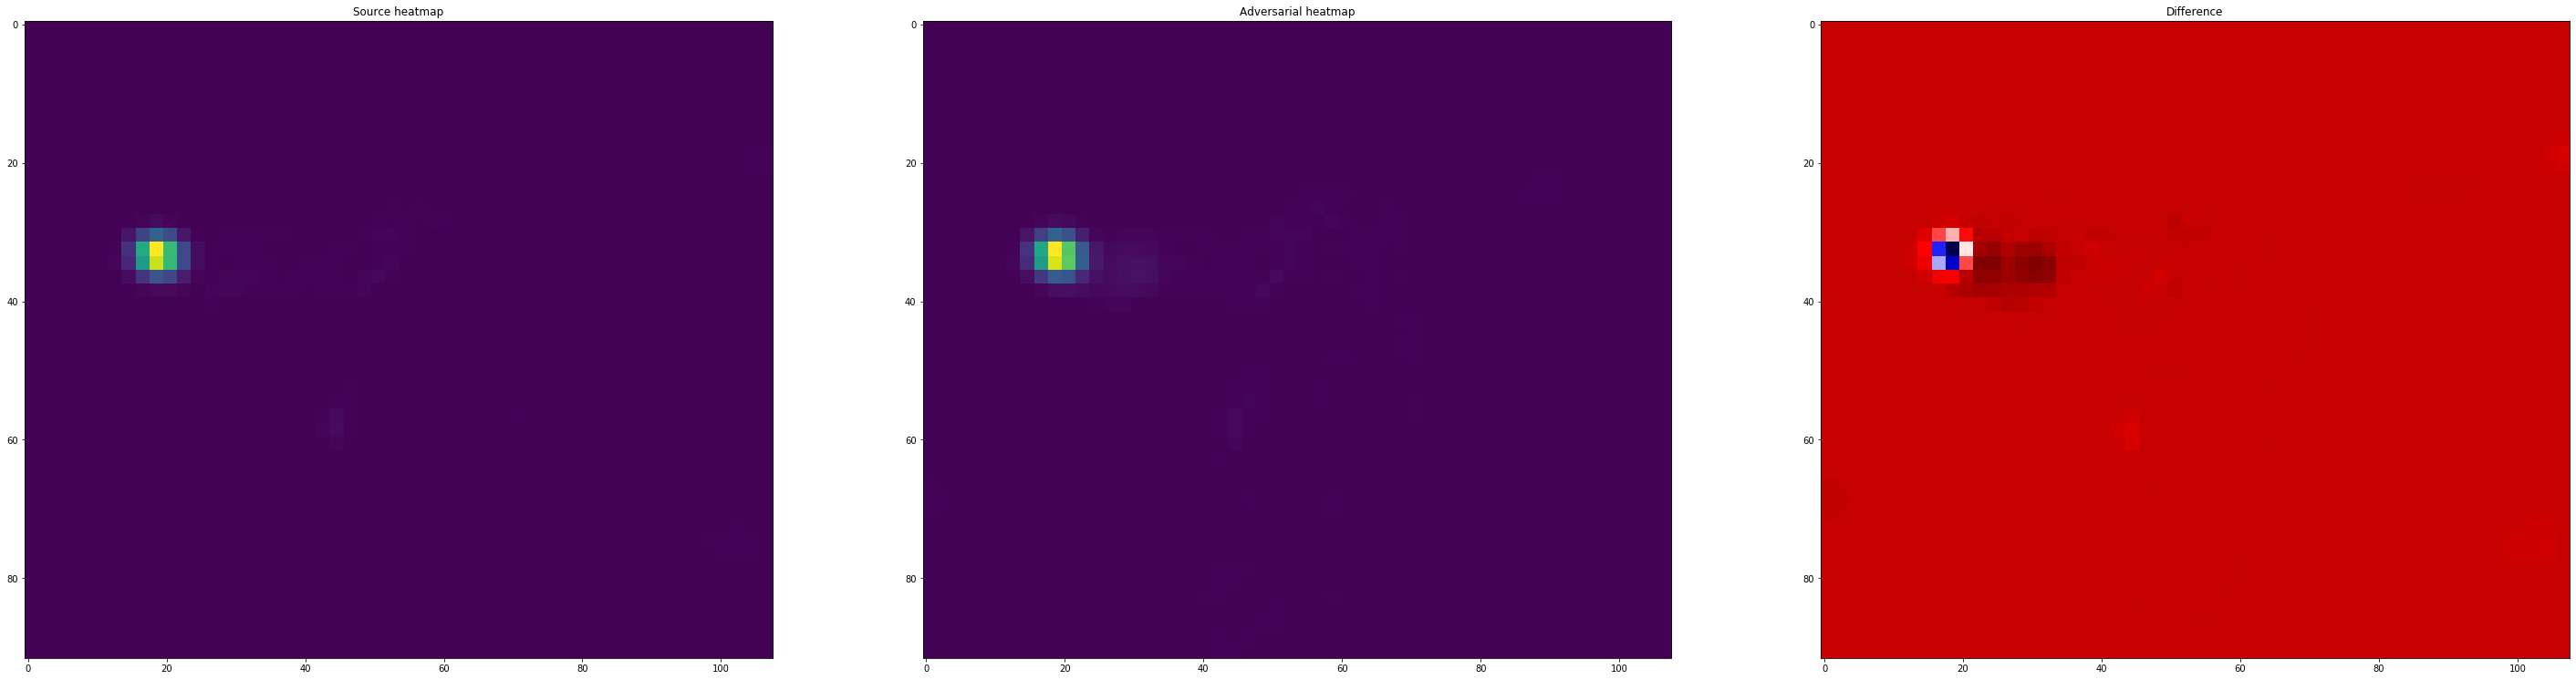

In [80]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source heatmap')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
ax.set_title('Adversarial heatmap')

print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
ax.set_title('Difference')

In [81]:
def compute_peaks(tensor_heat_placeholder):
    tensor_heatMat_up = tf.image.resize_area(tensor_heat_placeholder, upsample_size,
                                                          align_corners=False, name='upsample_heatmat')

    smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
    gaussian_heatMat = smoother.get_output()

    max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
    tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
    tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
    e_source.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e_source.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )
    return tensor_peaks




tensor_heat_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
tensor_peaks = compute_peaks(tensor_heat_placeholder)

# run for adversarial imape 
[adv_np_peaks] = e_source.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heat_placeholder: np.expand_dims(e_source.heatMat, axis=0)
            }
        )

Over all difference 0.1663561314344406
Localation of the peak in source (33, 19)
Localation of the peak in adv (34, 19)
Localation of the peak in adv (26, 26)


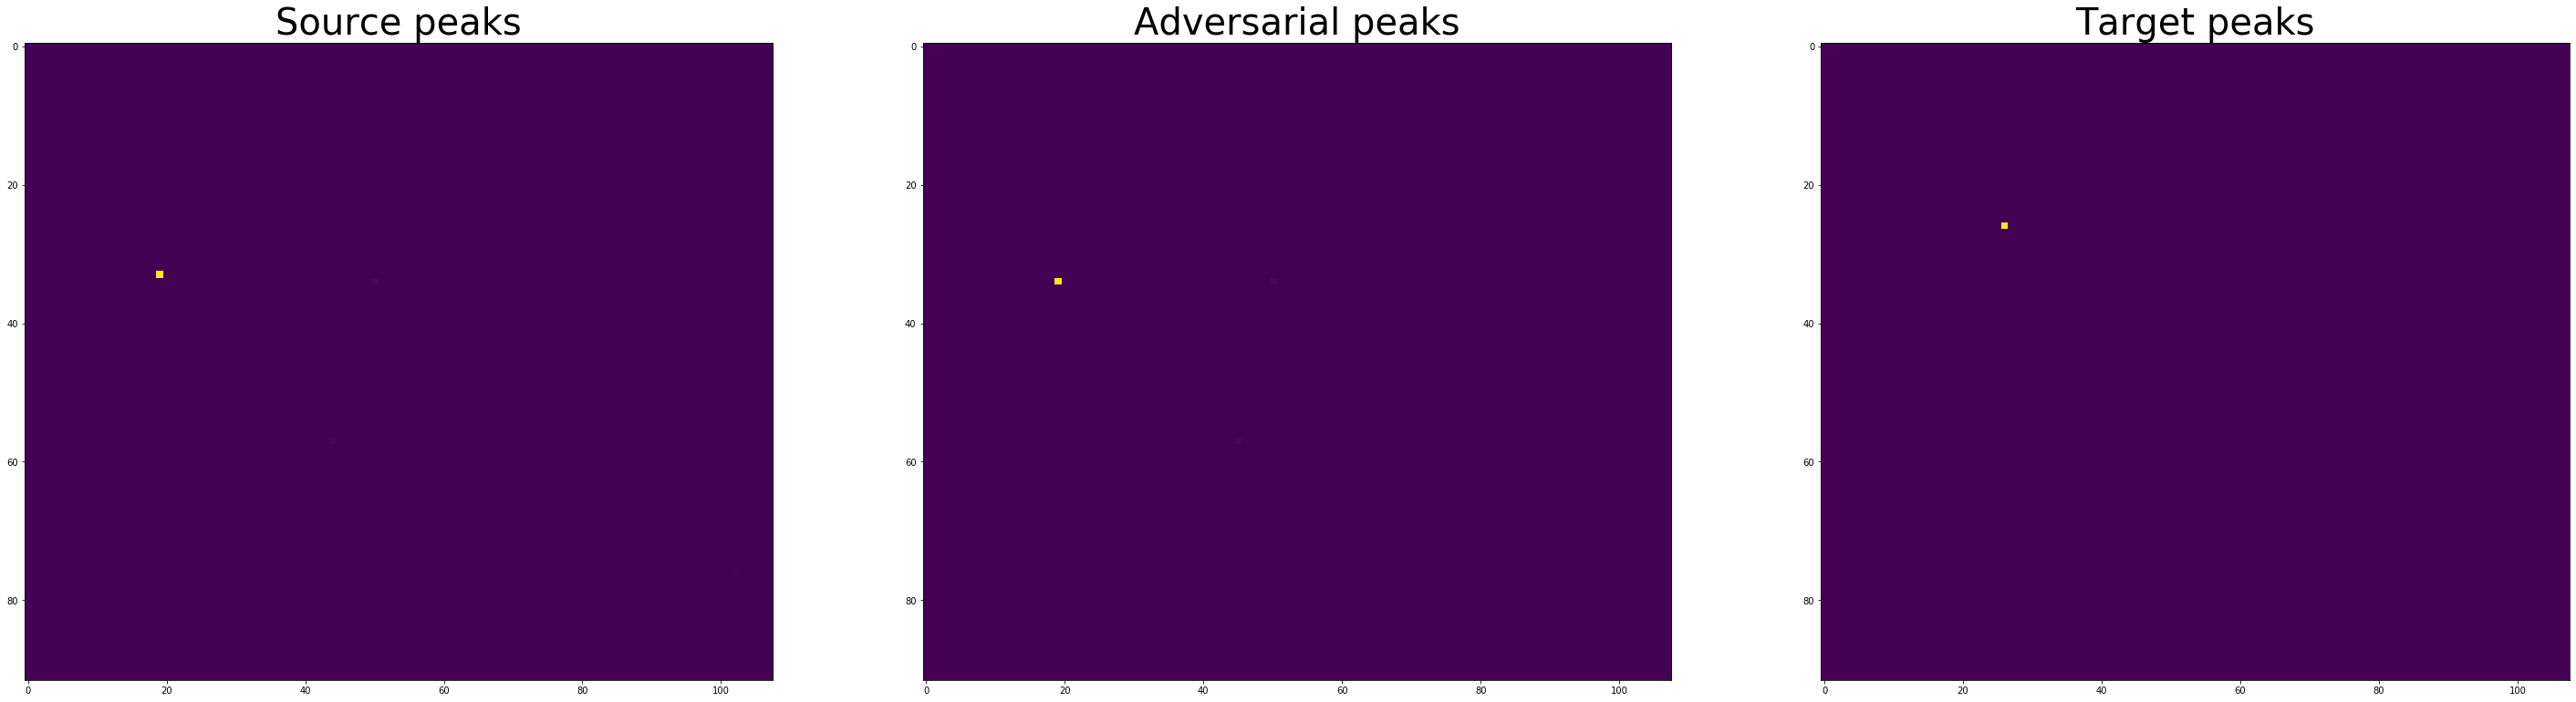

In [82]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_peaks[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source peaks', fontdict = {'fontsize' : 40})

ax = fig.add_subplot(1, 3, 2)
ax.imshow(adv_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Adversarial peaks', fontdict = {'fontsize' : 40})

print(f'Over all difference {is_same_image(adv_np_peaks[0, : ,:, CocoPart.RWrist.value], source_np_peaks[0, :, :, CocoPart.RWrist.value])}')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(target_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Target peaks', fontdict = {'fontsize' : 40})

print(f'Localation of the peak in source {np.unravel_index(source_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), source_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(adv_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), adv_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(target_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), target_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')